# YOLO Detection

In [2]:
!pip install -U mxnet-cu101==1.7.0
!pip install gluoncv

     |███████████████████████████████▌| 834.1MB 1.4MB/s eta 0:00:09tcmalloc: large alloc 1147494400 bytes == 0x664e0000 @  0x7fbcd1478615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 819kB 12.9MB/s 


In [3]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import mxnet as mx
import numpy as np
import cv2

In [4]:
ctx = mx.gpu(0)
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True, ctx=ctx)
person_ind = [i for i, cls in enumerate(net.classes) if cls == 'person'][0]

223070KB [00:03, 63549.11KB/s]                            


In [5]:
print(mx.context.gpu())

gpu(0)


In [6]:
vidcap = cv2.VideoCapture('VIRAT_S_000201_08_001652_001838.mp4')
success, image = vidcap.read()
count = 0

#
video_bbs = []
#

while success:
  img = mx.nd.array(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  x, img = data.transforms.presets.yolo.transform_test(img, short=512)

  # run the network
  x = x.as_in_context(ctx)
  class_IDs, scores, bounding_boxs = net(x)

  ids_arr = class_IDs[0].asnumpy()
  scores_arr = scores[0].asnumpy()
  boxes_arr = bounding_boxs[0].asnumpy()


  inds = np.where(ids_arr[:,0] == person_ind)[0]

  # extract only the people
  class_IDs = mx.nd.array(ids_arr[inds])
  scores = mx.nd.array(scores_arr[inds])
  bounding_boxs = mx.nd.array(boxes_arr[inds])

  success,image = vidcap.read()
  count += 1

  #
  video_bbs.append(bounding_boxs)
  #

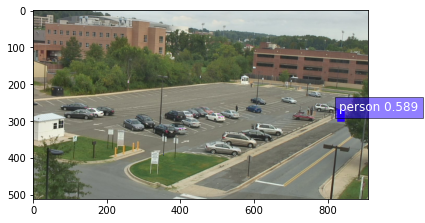

In [7]:
ax = utils.viz.plot_bbox(img, bounding_boxs, scores,
                         class_IDs, class_names=net.classes)
plt.show()

## Generalized Bounding Box Approach

In [43]:
bounding_boxs.asnumpy()

array([[832.7896 , 274.33163, 841.89777, 298.46042],
       [809.4842 , 272.58206, 816.9102 , 297.91922]], dtype=float32)

In [54]:
def extract_traits(bounding_box):
    """ Given bounding box coordinates, extracts relevant bounding box traits.
        Returns a dictionary that stores the height, width, and center coordinate of the
        given bounding box.
        Inputs:
            bounding_box - bounding box coordinates, given as an ndarray in the form 
            [y1, x1, y2, x2].
        Returns:
            height - height of bounding box.
            width - width of bounding box.
            centerx - x-coordinate of center of bounding box.
            centery - y-coordinate of center of bounding box.
    """
    # calculate height (in pixels) by taking difference between top and bottom
    height = np.abs(bounding_box[2]-bounding_box[0])
    # calculate width (in pixels) by taking difference between left and right
    width = np.abs(bounding_box[3]-bounding_box[1])
    # calculate center (in pixel coords) by taking averages of x and y coordinates
    centerx = np.mean([bounding_box[1],bounding_box[3]])
    centery = np.mean([bounding_box[0],bounding_box[2]])
    return height, width, centerx, centery

def get_distances_simpleaverage(box_list):
    """ Uses a simple average to determine the distance between bounding boxes of 
        identified objects within an image, given a list of bounding box coordinates.
        Inputs:
            box_list - list of bounding box coordinates, where each entry in the list is
                a set of bounding box coordinates, given as an ndarray in the form 
                [y1, x1, y2, x2].
        Returns:
            avg_distance - the average distance between all the bounding box center points.
            distance_array - array that contains the pairwise distances between each 
                bounding box's center point and the other bounding boxes' center points.
    """
    if len(box_list) == 0:
        print("No detections in this image!")
        return None, None
    else:
        # create list to store all data
        res = []
        for entry in box_list:
            # extract traits into array
            res.append(extract_traits(entry))
        res = np.array(res)
        # calculate pixel to feet ratio based on average height of 5.4 feet
        avg_height = np.mean(res[:,0])
        ft2px_ratio = 5.4 / avg_height
        # calculate distance between each pair of center points
        distance_array = []
        for center in res[:,2:]:
            distance_array.append(np.linalg.norm(center-res[:,2:], axis=1))
        distance_array = np.array(distance_array) * ft2px_ratio
        # average distance
        avg_distance = sum(sum(distance_array))/(np.square(len(distance_array))-len(distance_array))
        return avg_distance, distance_array

def count_undistanced(distance_array):
    """ Counts the number of pairs of people violating social distancing norms (not being
        more than 6 feet apart) given an array containing the pairwise distances between 
        identified bounding boxes.
        Inputs:
            distance_array - array that contains the pairwise distances between each 
                bounding box's center point and the other bounding boxes' center points.
        Returns:
            num_pairs - number of pairs of people in image not socially distanced.
            pair_ids - bounding box indexes of the people not socially distanced.
    """
    if distance_array is None:
        print("No distance array provided.")
        return None, None
    else:
        # remove duplicates in pairwise array (get upper triangular boolean)
        distance_bool_singles = np.triu(distance_array < 6)
        distance_bool_singles[np.eye(len(distance_array), dtype=bool)] = False
        # count the number of pairs of people less than 6 feet apart
        num_pairs = sum(sum(distance_bool_singles))
        # find the index of people not distancing
        pair_ids = np.argwhere(distance_bool_singles==True)
        return num_pairs, pair_ids

In [59]:
count_nondistanced = 0

for idx, image_bbs in enumerate(video_bbs):

  print("frame #:", idx)

  avg_distance, distance_array = get_distances_simpleaverage(image_bbs.asnumpy())
  num_pairs, pair_ids = count_undistanced(distance_array)
  if num_pairs is not None:
    count_nondistanced += num_pairs

  print("Average distance between people:", avg_distance)
  print("Number of pairs of people not socially distanced:", num_pairs)
  print("Pairwise distance array:\n", distance_array) 

  print("")

frame #: 0
Average distance between people: 188.3139190673828
Number of pairs of people not socially distanced: 0
Pairwise distance array:
 [[  0.      280.2837   37.01092]
 [280.2837    0.      247.64714]
 [ 37.01092 247.64714   0.     ]]

frame #: 1
Average distance between people: 183.0667470296224
Number of pairs of people not socially distanced: 0
Pairwise distance array:
 [[  0.       272.4383    36.039764]
 [272.4383     0.       240.72218 ]
 [ 36.039764 240.72218    0.      ]]

frame #: 2
Average distance between people: 181.27745056152344
Number of pairs of people not socially distanced: 0
Pairwise distance array:
 [[  0.       269.83374  238.39992 ]
 [269.83374    0.        35.598698]
 [238.39992   35.598698   0.      ]]

frame #: 3
Average distance between people: 183.16790771484375
Number of pairs of people not socially distanced: 0
Pairwise distance array:
 [[  0.       272.53687  240.7511  ]
 [272.53687    0.        36.215744]
 [240.7511    36.215744   0.      ]]

frame #

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars


Streaming output truncated to the last 5000 lines.
frame #: 4930
No detections in this image!
No distance array provided.
Average distance between people: None
Number of pairs of people not socially distanced: None
Pairwise distance array:
 None

frame #: 4931
No detections in this image!
No distance array provided.
Average distance between people: None
Number of pairs of people not socially distanced: None
Pairwise distance array:
 None

frame #: 4932
No detections in this image!
No distance array provided.
Average distance between people: None
Number of pairs of people not socially distanced: None
Pairwise distance array:
 None

frame #: 4933
No detections in this image!
No distance array provided.
Average distance between people: None
Number of pairs of people not socially distanced: None
Pairwise distance array:
 None

frame #: 4934
No detections in this image!
No distance array provided.
Average distance between people: None
Number of pairs of people not socially distanced: None
P

In [61]:
print("Total # frames:", len(video_bbs))
print("# of occurrences of no social distancing:", count_nondistanced)

Total # frames: 5580
# of occurrences of no social distancing: 195
